<a href="https://colab.research.google.com/github/Manvithtech07/Forest-Fire-Detection-And-Prediction/blob/main/notebooks/modeling_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/drive/My Drive/data/forestfire.csv")
print("Initial shape:", df.shape)
df.head()

Initial shape: (10000, 9)


,ndvi_pre,ndvi_post,nbr_pre,nbr_post,elevation,slope,aspect,dNBR,Burned
0,0.308193,0.122559,0.271816,0.000976,370.41125,89.99211,52.481003,0.270840,1
1,0.356812,0.135231,0.333193,0.062665,350.72733,89.96256,61.969288,0.270528,1
2,0.328753,0.126444,0.307496,0.000423,300.10056,89.98099,217.747300,0.307073,1
3,0.350441,0.132568,0.306111,0.012674,289.57400,89.98431,40.205303,0.293437,1
4,0.351877,0.128189,0.321083,0.039310,319.29330,89.99313,120.985435,0.281773,1


In [6]:
GDRIVE_PROJECT_PATH = "/content/drive/My Drive/"
DATA_PATH = f"{GDRIVE_PROJECT_PATH}/data"
FEATURES_PATH = f"{DATA_PATH}/features"
PROCESSED_PATH = f"{DATA_PATH}/processed"

In [7]:
df = df.replace({
    -32767: np.nan,
    -9999: np.nan
})
df = df.dropna()
df["Burned"] = df["Burned"].astype(int)

In [8]:
print(df.shape)
df.head()

(9975, 9)


,ndvi_pre,ndvi_post,nbr_pre,nbr_post,elevation,slope,aspect,dNBR,Burned
0,0.308193,0.122559,0.271816,0.000976,370.41125,89.99211,52.481003,0.270840,1
1,0.356812,0.135231,0.333193,0.062665,350.72733,89.96256,61.969288,0.270528,1
2,0.328753,0.126444,0.307496,0.000423,300.10056,89.98099,217.747300,0.307073,1
3,0.350441,0.132568,0.306111,0.012674,289.57400,89.98431,40.205303,0.293437,1
4,0.351877,0.128189,0.321083,0.039310,319.29330,89.99313,120.985435,0.281773,1


In [9]:
y = df["Burned"]
# We drop ALL post-fire features and the target-related features
X = df.drop(columns=["Burned", "dNBR", "ndvi_post", "nbr_post"])

print("Features (X) used for training:")
print(X.columns.to_list())
print("\nTarget (y) is 'Burned'")

Features (X) used for training:
['ndvi_pre', 'nbr_pre', 'elevation', 'slope', 'aspect']

Target (y) is 'Burned'


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (7980, 5)
Testing shape: (1995, 5)


In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
lr_grid = {"C": [0.1, 1, 10], "penalty": ["l2"]}
lr = LogisticRegression(max_iter=200, solver="lbfgs")
lr_search = GridSearchCV(lr, lr_grid, cv=cv, scoring="accuracy", n_jobs=-1)
lr_search.fit(X_train_scaled, y_train)

# SVM
svm_grid = {"C": [0.1, 1], "gamma": ["scale"]}
svm = SVC(kernel="rbf", probability=True)
svm_search = GridSearchCV(svm, svm_grid, cv=cv, scoring="accuracy", n_jobs=-1)
svm_search.fit(X_train_scaled, y_train)

# Random Forest
rf_grid = {"n_estimators": [100, 200], "max_depth": [None, 10]}
rf = RandomForestClassifier(random_state=42)
rf_search = GridSearchCV(rf, rf_grid, cv=cv, scoring="accuracy", n_jobs=-1)
rf_search.fit(X_train, y_train) # RF doesn't need scaled data


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [12]:
from sklearn.metrics import accuracy_score, classification_report

results = {}
results["Logistic Regression"] = accuracy_score(y_test, lr_search.best_estimator_.predict(X_test_scaled))
results["SVM"] = accuracy_score(y_test, svm_search.best_estimator_.predict(X_test_scaled))
results["Random Forest"] = accuracy_score(y_test, rf_search.best_estimator_.predict(X_test))

print(results)

rf_preds = rf_search.best_estimator_.predict(X_test)
print(classification_report(y_test, rf_preds))

{'Logistic Regression': 0.9413533834586466, 'SVM': 0.9468671679197995, 'Random Forest': 0.9488721804511279}
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       997
           1       0.96      0.94      0.95       998

    accuracy                           0.95      1995
   macro avg       0.95      0.95      0.95      1995
weighted avg       0.95      0.95      0.95      1995



     Feature  Importance
1    nbr_pre    0.468470
0   ndvi_pre    0.356017
3      slope    0.086204
2  elevation    0.071250
4     aspect    0.018059


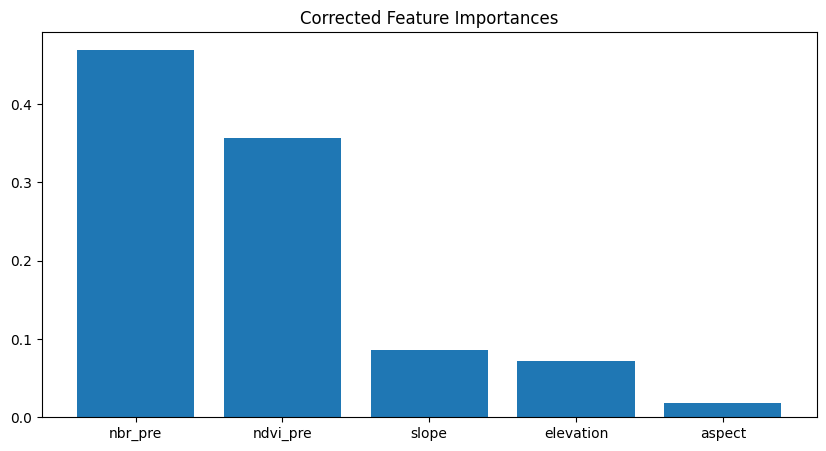

In [13]:
import matplotlib.pyplot as plt

rf_best = rf_search.best_estimator_

fi = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_best.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(fi)

plt.figure(figsize=(10, 5))
plt.bar(fi["Feature"], fi["Importance"])
plt.title("Corrected Feature Importances")
plt.show()

Confusion Matrix:


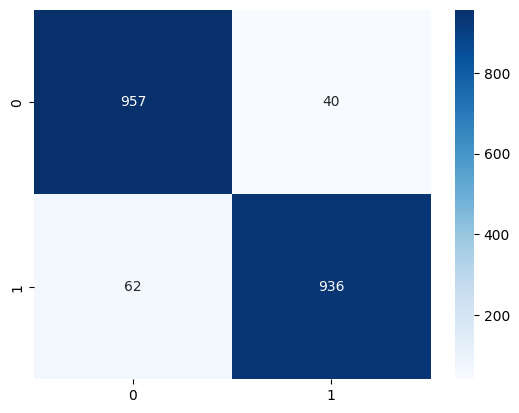

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix:")
cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [15]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 100.5 MB/s eta 0:00:00


In [16]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling

def clip_raster_to_shape(raster_path, shape_gdf, output_path):
    if os.path.exists(output_path):
        print(f"File exists {os.path.basename(output_path)}")
        return

    with rasterio.open(raster_path) as src:
        shape_gdf_reprojected = shape_gdf.to_crs(src.crs)
        geometries = shape_gdf_reprojected.geometry.values
        out_image, out_transform = mask(src, geometries, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": src.nodata
    })

    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)
    print(f"Clipped: {os.path.basename(output_path)}")


def align_to_master(src_path, master_meta, resampling_method):
    with rasterio.open(src_path) as src:
        dst = np.empty((master_meta['height'], master_meta['width']), dtype=src.dtypes[0])

        reproject(
            source=src.read(1),
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=master_meta['transform'],
            dst_crs=master_meta['crs'],
            resampling=resampling_method
        )
    return dst

In [17]:
import os

shapefile_path = f"{DATA_PATH}/Vector Layer (Shapefile)/IND_adm2.shp"
all_districts_gdf = gpd.read_file(shapefile_path)
nainital_gdf = all_districts_gdf[all_districts_gdf['NAME_2'] == "Naini Tal"]

master_path = f"{FEATURES_PATH}/ndvi_pre.tif"
with rasterio.open(master_path) as src:
    master_meta = src.meta.copy()
    H, W = src.height, src.width
print(f"Master grid set to: {(H, W)}")

raw_lulc_filename = "ESA_WorldCover_10m_2021_V200_N27E078_Map.tif"
raw_lulc_path = f"{DATA_PATH}/{raw_lulc_filename}"
clipped_lulc_path = f"{PROCESSED_PATH}/clipped_lulc_2021.tif"
aligned_lulc_path = f"{FEATURES_PATH}/aligned_lulc_2021.tif"

clip_raster_to_shape(raw_lulc_path, nainital_gdf, clipped_lulc_path)

aligned_lulc = align_to_master(clipped_lulc_path, master_meta, Resampling.nearest)

lulc_meta = master_meta.copy()
lulc_meta.update(dtype='uint8', nodata=0)
with rasterio.open(aligned_lulc_path, "w", **lulc_meta) as dst:
    dst.write(aligned_lulc.astype(np.uint8), 1)
print(f"LULC map aligned and saved to: {aligned_lulc_path}")

feature_names = [
    "ndvi_pre",
    "nbr_pre",
    "elevation",
    "slope",
    "aspect"
]

layers = []
for name in feature_names:
    path = f"{FEATURES_PATH}/{name}.tif"
    aligned_layer = align_to_master(path, master_meta, Resampling.bilinear)
    layers.append(aligned_layer)
    print(f"Aligned: {name}")

stack = np.stack(layers, axis=-1)
print(f"Final stack shape for prediction: {stack.shape}")

Master grid set to: (2337, 3669)
File exists clipped_lulc_2021.tif
LULC map aligned and saved to: /content/drive/My Drive//data/features/aligned_lulc_2021.tif
Aligned: ndvi_pre
Aligned: nbr_pre
Aligned: elevation
Aligned: slope
Aligned: aspect
Final stack shape for prediction: (2337, 3669, 5)


In [18]:
rf = rf_search.best_estimator_

flat_data = stack.reshape(-1, stack.shape[-1])
valid_mask = ~np.any(np.isnan(flat_data), axis=1)
valid_data = flat_data[valid_mask]

probs = rf.predict_proba(valid_data)[:, 1]

prob_map = np.full(flat_data.shape[0], np.nan)
prob_map[valid_mask] = probs
prob_map = prob_map.reshape(H, W)

with rasterio.open(aligned_lulc_path) as src:
    lulc_map = src.read(1)


is_burnable_vegetation = (
    (lulc_map == 10) |  # Tree cover
    (lulc_map == 20) |  # Shrubland
    (lulc_map == 30)    # Grassland
)

#   Apply Mask and Save Final Map
prob_map_filtered = prob_map.copy()
prob_map_filtered[~is_burnable_vegetation] = 0  # Set all non-forest/shrub/grassland to 0

# Apply a 50% probability threshold
burn_map = (prob_map_filtered > 0.5).astype(np.uint8)

print(f"Final Corrected Burned pixels: {burn_map.sum()}")

out_meta = master_meta.copy()
out_meta.update(dtype="uint8", count=1, nodata=0)
output_path_final = f"{FEATURES_PATH}/FINAL_BURN_MAP_LULC_CORRECTED.tif"

with rasterio.open(output_path_final, "w", **out_meta) as dst:
    dst.write(burn_map, 1)

print(f"Final LULC-corrected burn map saved to: {output_path_final}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Final Corrected Burned pixels: 53661
Final LULC-corrected burn map saved to: /content/drive/My Drive//data/features/FINAL_BURN_MAP_LULC_CORRECTED.tif
